# Cantera Introduction
The following is a short run through of some cantera functionalities based on:
- [Cantera Python Tutorial](https://cantera.org/tutorials/python-tutorial.html)
- [Cantera Documentation](https://cantera.org/documentation/index.html)
- [CUSF Bamboo Cantera Example](https://github.com/cuspaceflight/bamboo/blob/master/examples/Cantera%20Example.ipynb)
- [GRI-Mech Website](http://combustion.berkeley.edu/gri-mech/)

Several reaction mechanism files (.yaml files - plain text files) are included with Cantera, including ones that model high-temperature air, a hydrogen/oxygen reaction mechanism, and a few surface reaction mechanisms.

In [59]:
import cantera as ct
import numpy as np

In [60]:
gas1 = ct.Solution('gri30.yaml') # choose mechanism for the solution

In [61]:
# Display gas properties
# gas1()

Thermodynamics generally requires that two properties in addition to composition information be specified to fix the intensive state of a substance (or mixture). The state of the mixture can be set using several combinations of two properties. The following are all equivalent:

In [62]:
gas1.TP = 1200, 101325           # temperature, pressure
gas1.TD = 1200, 0.0204723        # temperature, density
gas1.HP = 1.32956e7, 101325      # specific enthalpy, pressure
gas1.UV = 8.34619e6, 1/0.0204723 # specific internal energy, specific volume
gas1.SP = 85227.6, 101325        # specific entropy, pressure
gas1.SV = 85227.6, 1/0.0204723   # specific entropy, specific volume

Properties may be read independently or together:

In [63]:
print(gas1.T)
print(gas1.h)
print(gas1.UV)

1200.5188172713504
13302755.250164837
(8351530.632807602, 48.84649013545132)


The composition can be set in terms of either mole fractions (X) or mass fractions (Y). Mass and mole fractions can be set using dict objects, which is convenient in cases where the composition is stored in a variable or being computed:

In [64]:
phi = 0.8
gas1.Y = {'CH4':1, 'O2':2/phi, 'N2':2*3.76/phi} # setting mass fraction

When the composition alone is changed, the temperature and density are held constant. This means that the pressure and other intensive properties will change. The composition can also be set in conjunction with the intensive properties of the mixture:

In [65]:
gas1.TPX = 1200, 101325, 'CH4:1, O2:2, N2:7.52'
# gas1()

When setting the state, you can control what properties are held constant by passing the special value None to the property setter. For example, to change the specific volume to 2.1 m3/kg while holding entropy constant:

In [66]:
gas1.SV = None, 2.1

### Chemical Equilibrium
To set a gas mixture to chemical equilibrium - a state of chemical balance in a reversible reaction - use the equilibrate method.

The below statement sets the state of object g to the state of chemical equilibrium holding temperature and pressure fixed. We can choose different options for the parameters to be held fixed. Ther are:

- <b>HP</b>: fixed enthalpy and pressure (the one we most likely will use for chamber CEA)
- <b>UV</b>: fixed specific internal energy and specific volume
- <b>SV</b>: fixed specific entropy and specific volume
- <b>SP</b>: fixed specific entropy and pressure

In [67]:
g = ct.Solution('gri30.yaml')
g.TPX = 300.0, ct.one_atm, 'CH4:0.95,O2:2,N2:7.52'
g.equilibrate('TP')

### Example of Finding Exhaust Gas Properties / Chamber Conditions

In [68]:
# Chamber conditions
_pc = 2.758e+6                # Chamber pressure (Pa)
thrust = 4448.22             # Desired thrust (N)
p_amb = 101325               # Ambient pressure (Pa) - sea level pressure
OF = 10.25                   # OF mass ratio

# We define our gas mixture via propellant initial temperature, pressure, mass ratio
gas = ct.Solution('gri30.yaml')
gas.TPY = 300, _pc, "C2H6:1, N2O:10.25"   # Very approximate fuel/ox inlet temperature
# Solution properties before chemical equilibrium
# gas()

### Plotting Chamber Temperaturre vs OF ratio
We can plot the chmaber pressure vs OF ratio for our mixture:

In [69]:
import os
import matplotlib.pyplot as plt

# OF ratio:
OF = range(21)[4:] # range 4 to 20
P = 2.758e+6 # 400 PSI
T = list()

# populate T list:
for of in OF: 
    gas = ct.Solution('gri30.yaml')
    mixture = "C2H6:1, N2O:{}".format(of)
    gas.TPY = 300, _pc, mixture
    gas.equilibrate("HP") # Equilibrate keeping enthalpy and pressure constant 
    T.append(gas.T) # add chamber temperature

C:\Users\lukas\AppData\Local\Temp/ipykernel_25880/3303667823.py:14: UserWarning: ChemEquil::equilibrate: Temperature (3004.7876734220717 K) outside valid range of 300 K to 3000 K
  gas.equilibrate("HP") # Equilibrate keeping enthalpy and pressure constant


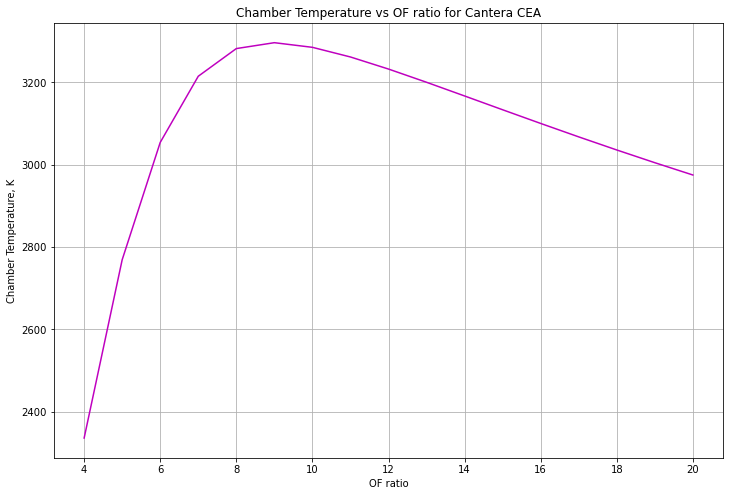

In [70]:
folder = "canteraplots/"
if not os.path.exists(folder):
        os.mkdir(folder)

# Plot results
fig, ax = plt.subplots(figsize=(12,8))
# set background color to white
fig.set_facecolor("white")
plt.grid()
plt.plot(OF, T, color="m")
ax.set_ylabel("Chamber Temperature, K")
ax.set_xlabel("OF ratio")
plt.title("Chamber Temperature vs OF ratio for Cantera CEA")
plt.savefig(folder + "TvsOF.png", dpi=300)

### Generating Chamber Pressure, Specific Heat Ratio (Throat and Chamber), and Molecular Weight for different OF values

In [71]:
import scipy.optimize

# Values to be inputted into Engine Sizing Equations
P = 2.758e+6 # 400 PSI

# define OF list
step = 0.2
N = 66
OF = range(N+1)[1:] # N values from step to N*step
OF = [x * step for x in OF]
print("using OF from", min(OF), max(OF))

using OF from 0.2 13.200000000000001


In [72]:
# define our error function
def throat_error(pt):
    gas.SP = s0, pt      
    gamma = gas.cp/gas.cv
    R = gas.cp * (1 - 1/gamma)
    V = np.sqrt(2 * (h0 - gas.h) )                # Definition of stagnation enthalpy
    error = V - np.sqrt(gamma * R * gas.T)        # Difference between actual and sonic velocity - must be zero at throat
    return error

Tc = list()
kc = list()
kt = list()
MW = list()

for of in OF: 
    gas = ct.Solution('gri30.yaml')
    mixture = "C2H6:1, N2O:{}".format(of)
    gas.TPY = 300, P, mixture
    gas.equilibrate("HP") # Equilibrate keeping enthalpy and pressure constant 
    
    # get results of inital conditions after equilibration
    s0 = gas.s
    h0 = gas.h 
    T0 = gas.T
    _kc = gas.cp / gas.cv
    MW_i = gas.mean_molecular_weight
    
    # converge on k_throat
    pt_guess = P * (1 + (_kc - 1) / 2) ** (-_kc / (_kc - 1))
    # Use scipy's solver to get throat conditions - you should use throat conditions with bamboo
    pt = scipy.optimize.fsolve(throat_error, x0 = pt_guess)
    kt_conv = gas.cp/gas.cv
    
    # populate lists
    Tc.append(gas.T) # add chamber temperature
    kc.append(gas.cp / gas.cv)
    kt.append(kt_conv)
    MW.append(MW_i)

C:\Users\lukas\AppData\Local\Temp/ipykernel_25880/3188796126.py:19: UserWarning: ChemEquil::equilibrate: Temperature (3007.6994395355514 K) outside valid range of 300 K to 3000 K
  gas.equilibrate("HP") # Equilibrate keeping enthalpy and pressure constant


In [73]:
import pandas as pd

folder = "canterafiles/"
if not os.path.exists(folder):
        os.mkdir(folder)
        
df = pd.DataFrame(list(zip(OF, Tc, kc, kt, MW)), columns =['OF', 'Tc', 'k_chamber', 'k_throat', 'Mean Molecular Weight'])
df.to_excel(folder + "exhaustgastandk.xlsx")

### Cantera for Coolant Modeling

In [74]:
# Set up the coolant transport properties using Cantera
coolant = ct.Solution('gri30.yaml')
coolant.TPY = 298.15, _pc, "N2O:1" # defining starting conditions for coolant to be at chamber pressure and standard ambient temperature

In [75]:
coolant()


  gri30:

       temperature   298.15 K
          pressure   2.758e+06 Pa
           density   48.967 kg/m^3
  mean mol. weight   44.013 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy         1.854e+06          8.16e+07  J
   internal energy        1.7977e+06        7.9121e+07  J
           entropy            4374.6        1.9254e+05  J/K
    Gibbs function        5.4971e+05        2.4194e+07  J
 heat capacity c_p            877.64             38627  J/K
 heat capacity c_v            688.73             30313  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
               N2O                 1                 1            9.7599
     [  +52 minor]                 0                 0  



In [76]:
def Pr_coolant(T, p):
    coolant.TP = T, p
    return coolant.cp * coolant.viscosity / coolant.thermal_conductivity # Definition of Prandtl number (from bamboo Cantera example)

def mu_coolant(T, p):
    coolant.TP = T, p
    return gas.viscosity

def k_coolant(T, p):
    coolant.TP = T, p
    return coolant.thermal_conductivity

def cp_coolant(T, p):
    coolant.TP = T, p
    return coolant.cp

def rho_coolant(T, p):
    coolant.TP = T, p
    return coolant.density_mass

### Get Oxidizer Properties

In [77]:
# set conditions for fuel
fuel = ct.Solution('gri30.yaml')
fuel.TPY = 300, _pc, "C2H6:1" # defining starting conditions for fuel to be at chamber pressure and standard ambient temperature

# extract viscosity and density from Cantera
def mu_fuel(T, p):
    fuel.TP = T, p
    return fuel.viscosity

def rho_fuel(T, p):
    fuel.TP = T, p
    return fuel.density_mass

# print viscosity and density
print("Viscosity of fuel at chamber conditions:", mu_fuel(300, _pc), "Pa*s", "\nDensity of fuel at chamber conditions:", rho_fuel(300, _pc), "kg/m^3")

Viscosity of fuel at chamber conditions: 9.366168038726339e-06 Pa*s 
Density of fuel at chamber conditions: 33.248514790332344 kg/m^3
